In [1]:
import numpy as np #For arrays and calculations
import matplotlib.pyplot as plt #For data visualisation and plottings
import seaborn as sns #For statistical data visualisation
import tensorflow as tf #For core library for machine learning and deep learning
from tensorflow import keras #For better model building 
from tensorflow.keras import Layer #For creating custom layers
from tensorflow.keras.models import Sequential #For building neural network layer by layer 
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D #For normalizing of pixel values and converting 2D parameters into 1D vector
from tensorflow.keras import layers, Model, Input, optimizers, callbacks #Imports for layering, optimizers and callbacks in keras
from sklearn.utils.class_weight import compute_class_weight #Importings function for computing class weights
from tensorflow.keras.applications import EfficientNetV2B2, EfficientNetV2B0, MobileNetV2 #Our main pre-trained model used for transfer learning
from sklearn.metrics import confusion_matrix, classification_report #Importing functions for evaluating model performance

In [2]:
#Loading of training data with specified parameters
train_ds = tf.keras.utils.image_dataset_from_directory(
r"D:\Paresh\Shell Internship\Data set\archive\TrashType_Image_Dataset",
validation_split = 0.2,
subset = 'training',
seed = 42,
shuffle = True,
image_size = (160,160),
batch_size = 32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [3]:
#Loading of validation data with specified parameters
val_ds = tf.keras.utils.image_dataset_from_directory(
r"D:\Paresh\Shell Internship\Data set\archive\TrashType_Image_Dataset",
validation_split = 0.2,
subset = 'validation',
seed = 42, 
shuffle = True,
image_size = (160,160),
batch_size = 32
)

val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)     #Total no. of batches in val_ds

#Splitting of val_ds into test data and validation data
test_ds = val_ds.take(val_batches // 2)
val_data = val_ds.skip(val_batches // 2)

# #Optimizing the test dataset by caching and prefetching 
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [5]:
#Checking if the classes are correct for the datasets
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


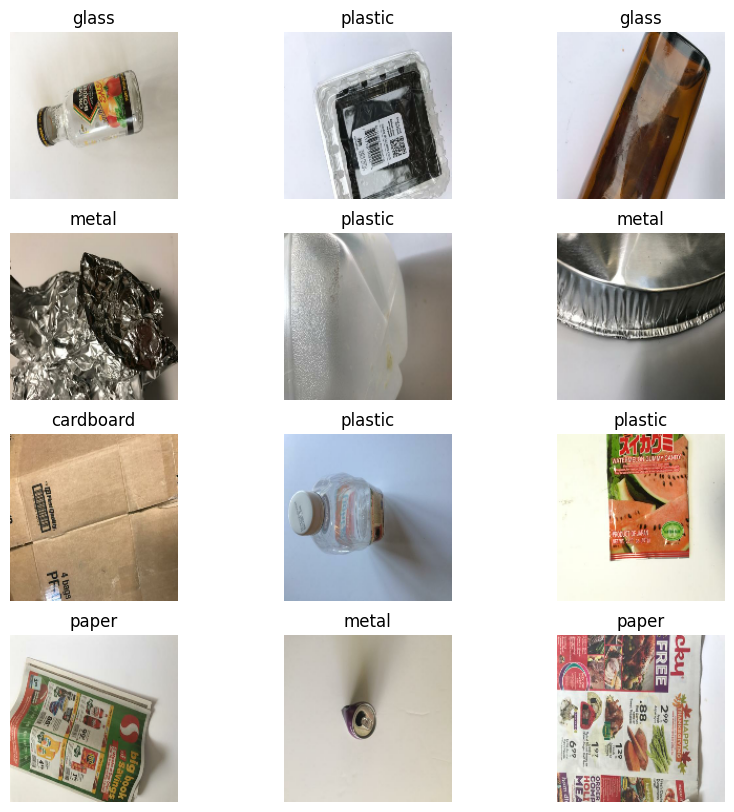

In [6]:
#Plotting of sample images from each class
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1): #Takes one batch from train_ds
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [7]:
#Counting the number of images per class to check for imbalance and understanding other properties like image dimensions and class labels.

from collections import Counter
def counting_images(dataset, class_names):
    
    count = Counter()
    
    for _, labels in dataset:
        count.update(labels.numpy())
        
    dic = {name : count[class_names.index(name)] for name in class_names}
    
    return dic

def percentage(dic):
    per = {x : round((dic[x] / sum(dic.values())) * 100,2)  for x in dic}
    return per
    
    


In [8]:
def plot_pie_chart(dic, title):
    plt.pie(dic.values(), labels = dic.keys(), autopct = '%1.1f%%', wedgeprops = {'edgecolor' : 'white', 'linewidth' : 1})
    plt.title(title)
    plt.legend(title = "Classes")
    plt.show()

In [9]:
def plot_bar_chart(dic, title):
    plt.bar(dic.keys(), dic.values(), color='cornflowerblue')
    plt.ylabel("Percentage (%)")
    plt.title(title)
    plt.ylim(0,100)
    plt.show()

In [10]:
# Data set visualisation
class_names = train_ds.class_names

train_dic = counting_images(train_ds, class_names)
val_dic = counting_images(val_ds, class_names)
test_dic = counting_images(test_ds, class_names)

overall_dic = {}
for k in class_names:
    overall_dic[k] = round((train_dic[k] + val_dic[k]) / 2, 2)
    
print(percentage(train_dic))
print(percentage(val_dic))
print(percentage(test_dic))
print(percentage(overall_dic))

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.95, 'glass': 19.83, 'metal': 16.22, 'paper': 23.51, 'plastic': 19.07, 'trash': 5.42}


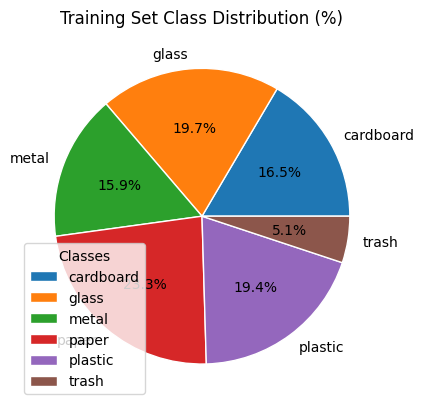

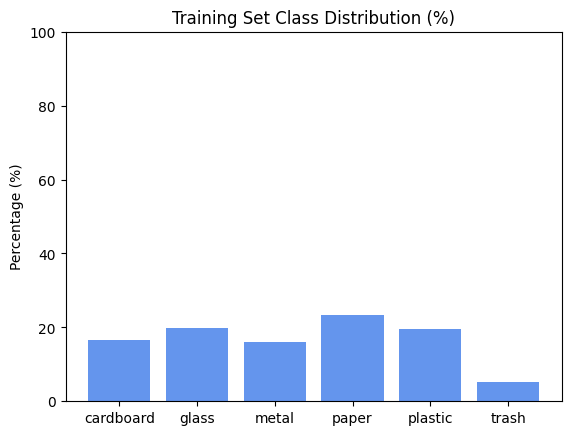

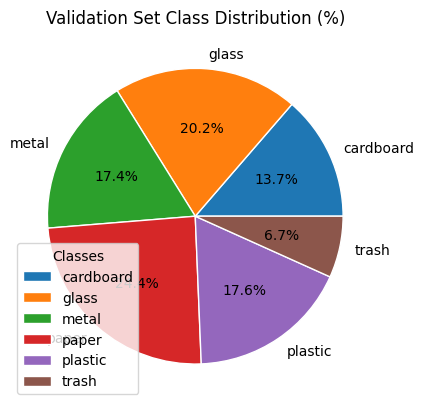

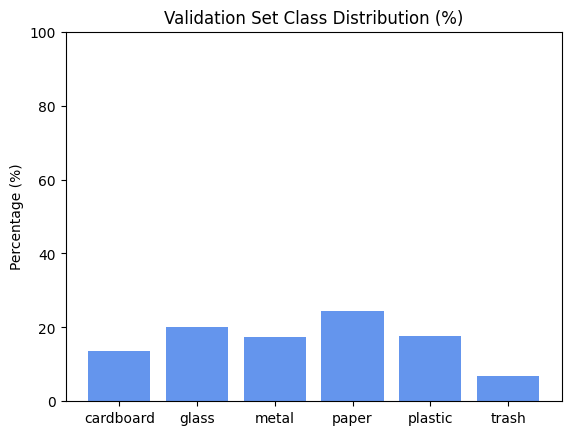

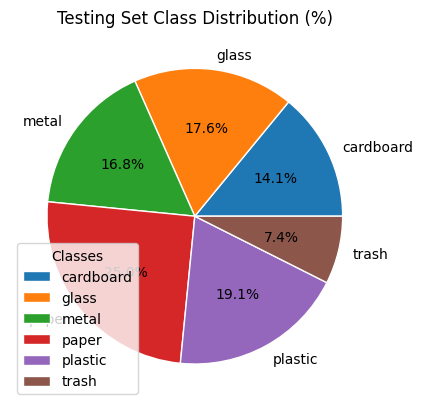

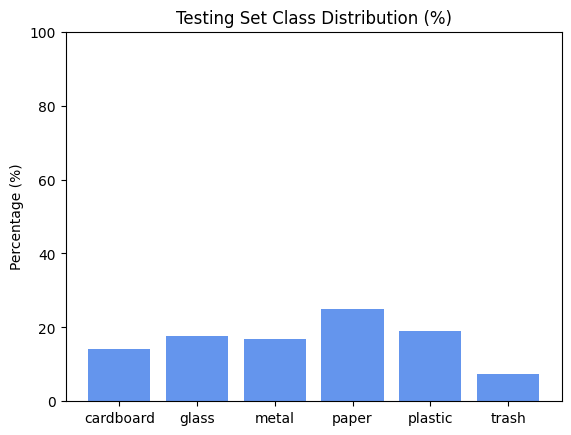

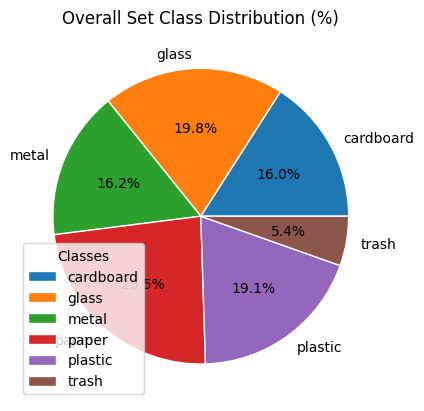

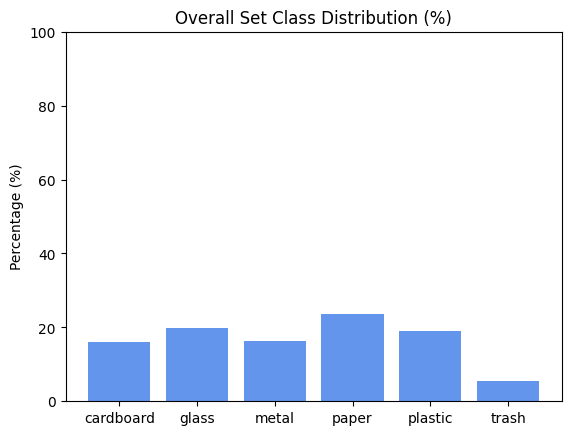

In [11]:
# Class Plots

plot_pie_chart(percentage(train_dic), "Training Set Class Distribution (%)")
plot_bar_chart(percentage(train_dic), "Training Set Class Distribution (%)")

plot_pie_chart(percentage(val_dic), "Validation Set Class Distribution (%)")
plot_bar_chart(percentage(val_dic), "Validation Set Class Distribution (%)")

plot_pie_chart(percentage(test_dic), "Testing Set Class Distribution (%)")
plot_bar_chart(percentage(test_dic), "Testing Set Class Distribution (%)")

plot_pie_chart(percentage(overall_dic), "Overall Set Class Distribution (%)")
plot_bar_chart(percentage(overall_dic), "Overall Set Class Distribution (%)")

In [12]:
# To handle imbalance of classes
# Introduce class weights

class_counts = Counter()
all_labels = []

for images, labels in train_ds:
    class_counts.update(labels.numpy())
    for label in labels.numpy():
        all_labels.append(label)
    
#Compute class weights
class_weights_array = compute_class_weight(
class_weight = 'balanced',
classes = np.arange(len(class_names)),
y = all_labels
)


class_weights = {i:w for i,w in enumerate(class_weights_array)}

print('Class counts:', dict(class_counts))
print('Class weights:', class_weights)


Class counts: {3: 471, 1: 399, 4: 393, 2: 322, 5: 103, 0: 334}
Class weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [13]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip('vertical'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [14]:
# Model Selection for transfer learning

#Loading our pretrained model
base_model = EfficientNetV2B2(include_top = False,
                             input_shape = (160,160,3),
                             include_preprocessing = True,
                             weights = 'imagenet')

# Early layers freezing to retain general pretrained features
base_model.trainable = True
for layer in base_model.layers[:160]:
    layer.trainable = False

In [15]:
#Model building
EN_B2_model = Sequential([
    layers.Input(shape = (160,160,3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(6, activation = 'softmax')
])

In [16]:
#Compiling the model
EN_B2_model.compile(
optimizer = optimizers.Adam(learning_rate = 1e-4),
loss= 'sparse_categorical_crossentropy',
metrics = ['accuracy']
)

In [17]:
#Early Stopping to monitor the validation loss
early = tf.keras.callbacks.EarlyStopping(
monitor = 'val_loss',
patience = 3,
restore_best_weights = True
)

In [18]:
#Summary
EN_B2_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 5, 5, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,179,410 (27.39 MB)

 Non-trainable params: 1,598,418 (6.10 MB)

In [19]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 160, 160, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 160, 160, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 80, 80, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 80, 80, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 80, 80, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 80, 80, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 80, 80, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 80, 80, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 80, 80, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 80, 80, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 80, 80, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 80, 80, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 80, 80, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 40, 40, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,170,956 (27.36 MB)

 Non-trainable params: 1,598,418 (6.10 MB)

In [20]:
#Fitting the data to our model
epochs = 15

history = EN_B2_model.fit(
train_ds,
validation_data = val_ds,
epochs = epochs,
class_weight = class_weights,
batch_size = 32,
callbacks = [early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.3278 - loss: 1.6664 - val_accuracy: 0.7069 - val_loss: 1.0596
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.6949 - loss: 1.0136 - val_accuracy: 0.8297 - val_loss: 0.6733
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7948 - loss: 0.6796 - val_accuracy: 0.8752 - val_loss: 0.4651
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8282 - loss: 0.4804 - val_accuracy: 0.8851 - val_loss: 0.3965
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8831 - loss: 0.3778 - val_accuracy: 0.8871 - val_loss: 0.3391
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8963 - loss: 0.3124 - val_accuracy: 0.8990 - val_loss: 0.2988
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9225 - loss: 0.2428 - val_accuracy: 0.8911 - val_loss: 0.2945
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9349 - loss: 0.2048 - val_accuracy: 0.9069 - v

In [21]:
# Performance Visualisation
def plot_training_validation_acc_loss(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize = (10,8))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training vs Validation Accuracy')
    plt.show()

    plt.figure(figsize = (10,8))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = "Validation Loss")
    plt.legend(loc = 'upper right')
    plt.title('Training vs Validation loss')

    plt.show()

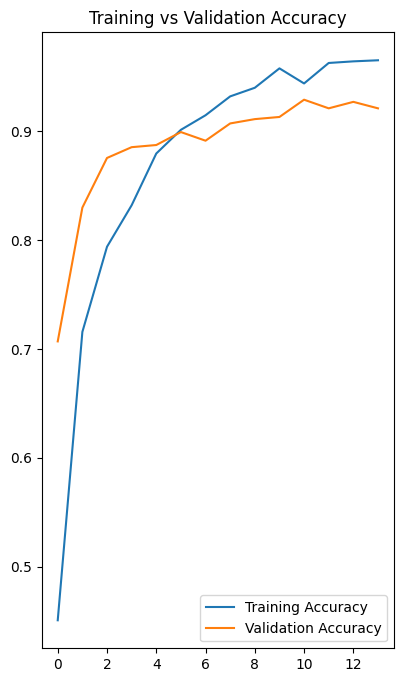

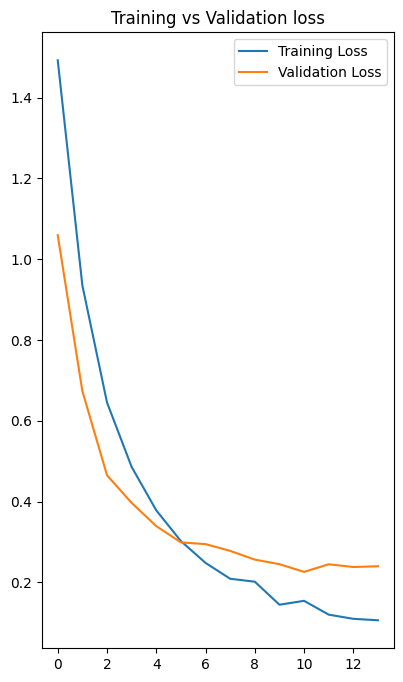

In [22]:
#Plotting
plot_training_validation_acc_loss(history)

In [23]:
#Test data evaluation
loss, accuracy = EN_B2_model.evaluate(test_ds_eval)
print(f"Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 921ms/step - accuracy: 0.9406 - loss: 0.1776
Test accuracy is 0.9453, Test loss is 0.1973


In [24]:
#Making confusion matrix and evaluating the test dataset using our model
y_true = np.concatenate([y.numpy() for x,y in test_ds_eval], axis = 0)

y_pred_probs = EN_B2_model.predict(test_ds_eval)

y_pred = np.argmax(y_pred_probs, axis = 1)

cm = confusion_matrix(y_true, y_pred)

#Displaying the results of the above evaluation
print(cm)
print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 874ms/step
[[28  0  0  2  0  0]
 [ 0 44  3  0  0  0]
 [ 0  1 48  0  0  1]
 [ 3  0  0 58  0  1]
 [ 0  1  0  0 43  1]
 [ 0  0  0  0  1 21]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.96      0.94      0.95        47
           2       0.94      0.96      0.95        50
           3       0.97      0.94      0.95        62
           4       0.98      0.96      0.97        45
           5       0.88      0.95      0.91        22

    accuracy                           0.95       256
   macro avg       0.94      0.95      0.94       256
weighted avg       0.95      0.95      0.95       256



In [25]:
np.shape(y_pred_probs)

(256, 6)

In [26]:
#Plotting of confusion matrix
def plot_confusion_matrix(cm, colour):
    plt.figure(figsize = (10,8))

    sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
                xticklabels=class_names,  # Set class names for x-axis (predicted labels)
                yticklabels=class_names,  # Set class names for y-axis (true labels)
                cmap=colour)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

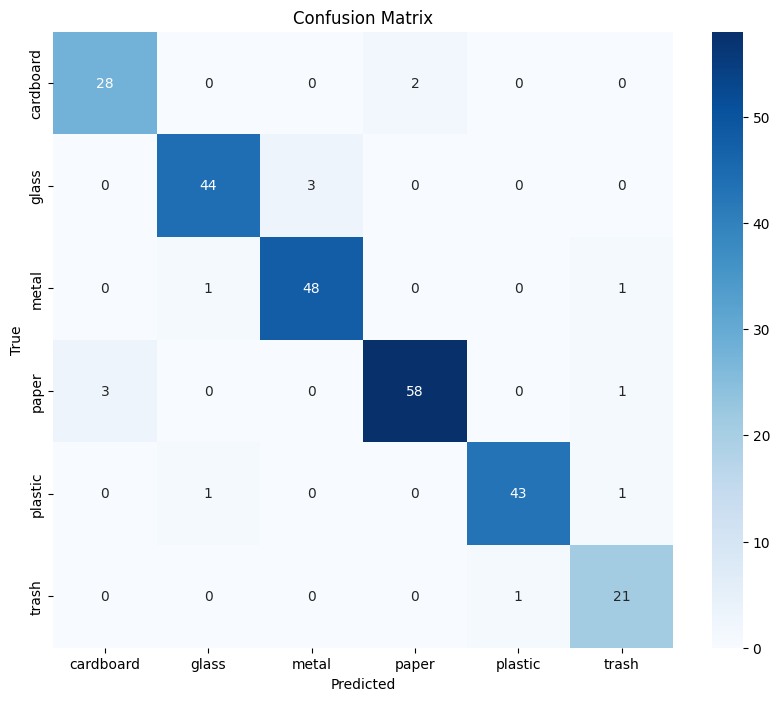

In [27]:
plot_confusion_matrix(cm, "Blues")

In [28]:
#Testing the model with test_ds to make predictions and displaying it

class_names = train_ds.class_names
def display_image_prediction(model, test_ds):
    
    for images, labels in test_ds.take(1):
        predictions = model.predict(images)
        pred_labels = tf.argmax(predictions, axis = 1)

        for i in range(8):
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
            plt.axis('off')
            plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


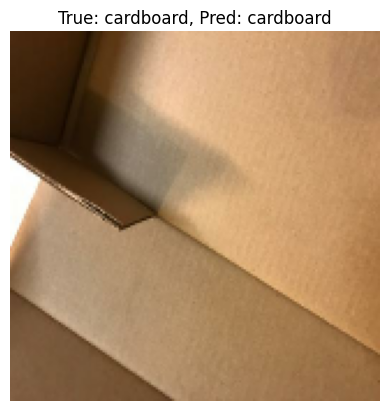

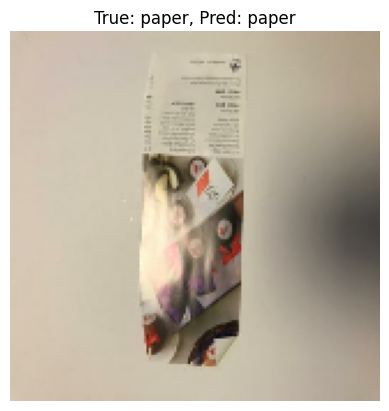

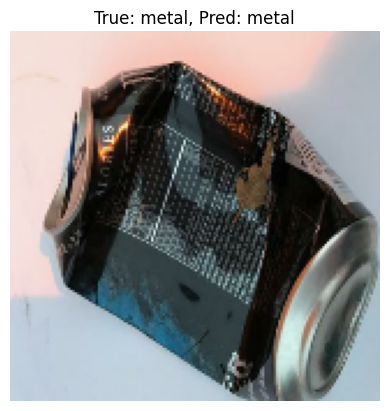

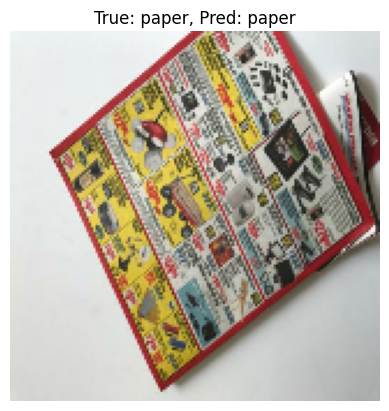

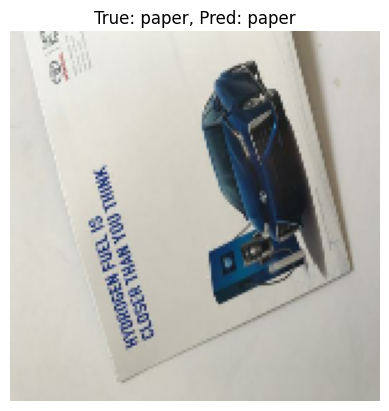

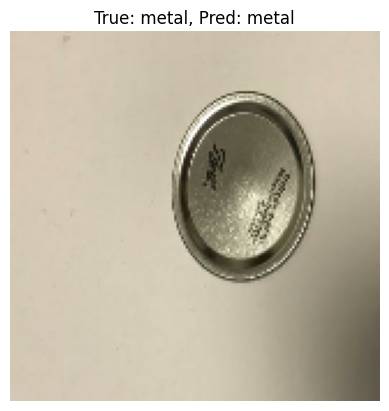

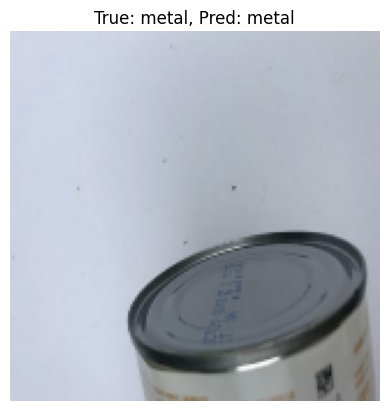

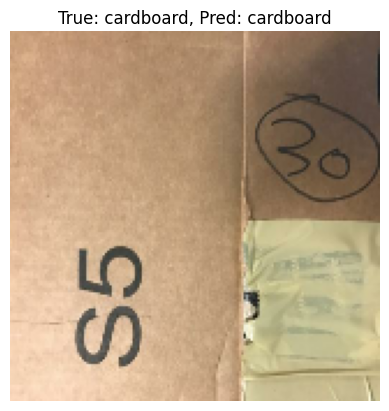

In [29]:
display_image_prediction(EN_B2_model, test_ds_eval)

In [30]:
#Saving the model
EN_B2_model.save('Efficientnetv2b2.keras')

#Loading the model
EN_B2_model = tf.keras.models.load_model('Efficientnetv2b2.keras')


In [31]:
#Implementing transfer learning using EfficientNetv2B0
base_model_1 = EfficientNetV2B0(include_top = False,
                            input_shape = (160,160,3),
                            include_preprocessing = True,
                            weights = 'imagenet')

base_model_1.trainable = True
for layer in base_model_1.layers[:110]:
    layer.trainable = False

In [32]:
#Building model EN_B0
EN_B0_model = Sequential([layers.Input(shape = (160,160,3)),
    data_augmentation,
    base_model_1,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation = 'softmax')
])

In [33]:
#Compiling model EN_B0
EN_B0_model.compile(
optimizer = optimizers.Adam(learning_rate = 1e-4),
loss= 'sparse_categorical_crossentropy',
metrics = ['accuracy']
)

In [34]:
EN_B0_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 5, 5, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,926,998 (22.61 MB)

 Trainable params: 5,003,846 (19.09 MB)

 Non-trainable params: 923,152 (3.52 MB)

In [35]:
base_model_1.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 160, 160, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 160, 160, 3)       │               0 │ rescaling_1[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 80, 80, 32)        │             864 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 80, 80, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 80, 80, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 80, 80, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 80, 80, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 80, 80, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 40, 40, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 40, 40, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 40, 40, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 40, 40, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 40, 40, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 4,996,160 (19.06 MB)

 Non-trainable params: 923,152 (3.52 MB)

In [36]:
#Fitting the data to the model
epochs = 15

history_1 = EN_B0_model.fit(
train_ds,
validation_data = val_ds,
epochs = epochs,
class_weight = class_weights,
batch_size = 32,
callbacks = [early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.3406 - loss: 1.6665 - val_accuracy: 0.6337 - val_loss: 1.1381
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6950 - loss: 1.0137 - val_accuracy: 0.7723 - val_loss: 0.7386
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7690 - loss: 0.7097 - val_accuracy: 0.8257 - val_loss: 0.5526
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8288 - loss: 0.5393 - val_accuracy: 0.8535 - val_loss: 0.4578
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8774 - loss: 0.4068 - val_accuracy: 0.8554 - val_loss: 0.4046
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8918 - loss: 0.3172 - val_accuracy: 0.8693 - val_loss: 0.3643
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9024 - loss: 0.2717 - val_accuracy: 0.8832 - val_loss: 0.3461
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9290 - loss: 0.2097 - val_accuracy: 0.8871 - v

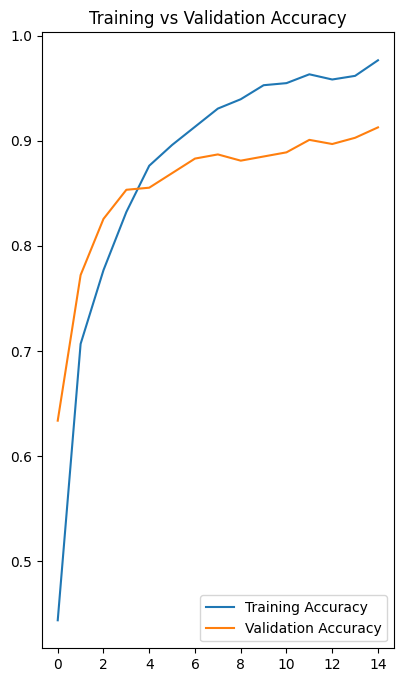

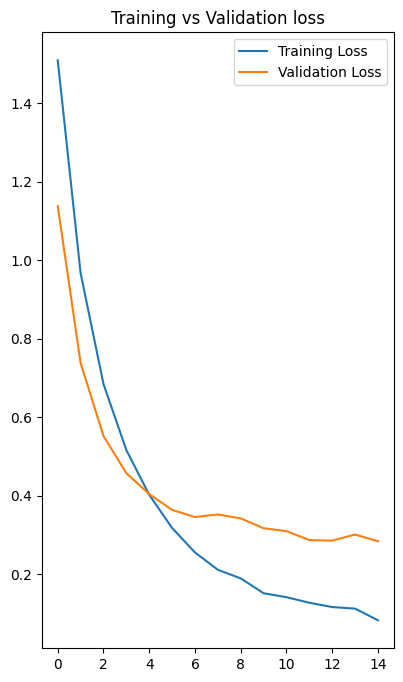

In [37]:
#Performance evaluation for the model EN_B0
plot_training_validation_acc_loss(history_1)

In [38]:
#Accuracy and Test for EN_B0
loss, accuracy = EN_B0_model.evaluate(test_ds_eval)
print(f"Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9171 - loss: 0.3008
Test accuracy is 0.9258, Test loss is 0.2788


In [39]:
#Confusion matrix building
y_pred_probs_1 = EN_B0_model.predict(test_ds_eval)

y_pred_1 = np.argmax(y_pred_probs_1, axis = 1)

cm_1 = confusion_matrix(y_true, y_pred_1)

print(cm_1)
print(classification_report(y_true, y_pred_1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
[[28  0  0  2  0  0]
 [ 0 41  4  0  2  0]
 [ 0  0 47  1  1  1]
 [ 2  0  0 60  0  0]
 [ 1  0  0  0 43  1]
 [ 0  0  1  3  0 18]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       1.00      0.87      0.93        47
           2       0.90      0.94      0.92        50
           3       0.91      0.97      0.94        62
           4       0.93      0.96      0.95        45
           5       0.90      0.82      0.86        22

    accuracy                           0.93       256
   macro avg       0.93      0.91      0.92       256
weighted avg       0.93      0.93      0.93       256



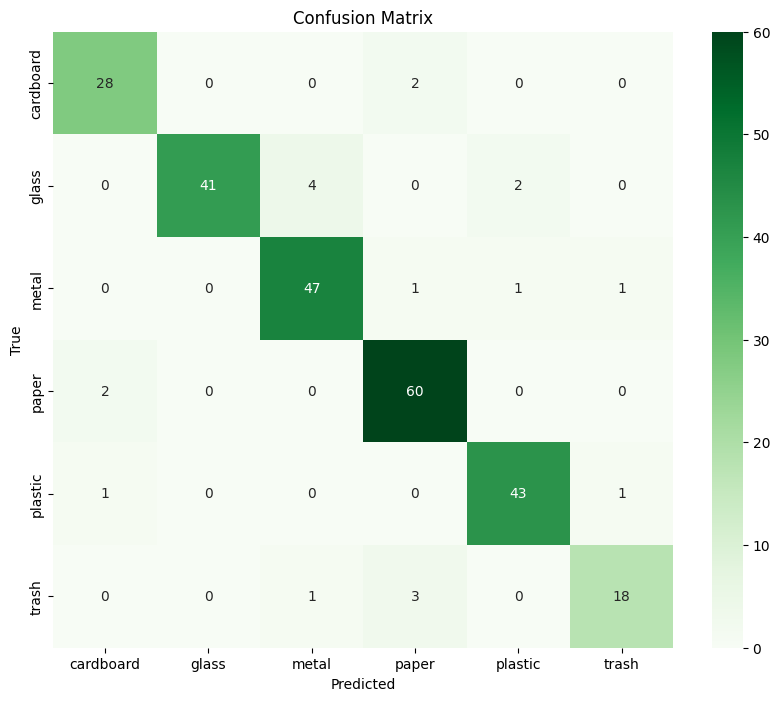

In [40]:
plot_confusion_matrix(cm_1, "Greens")

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


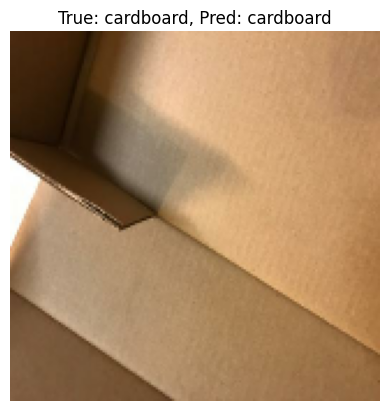

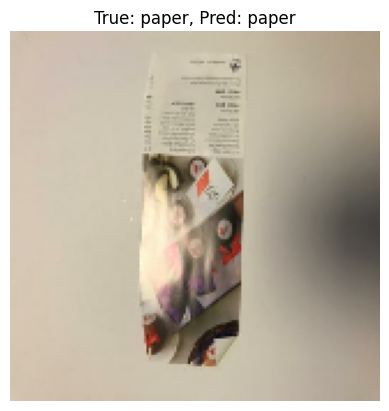

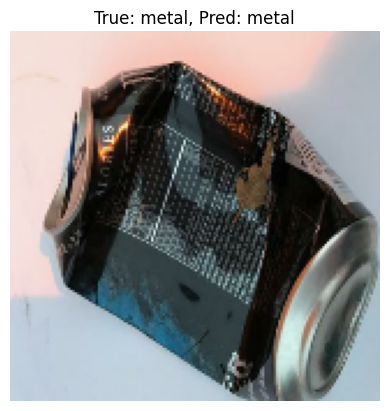

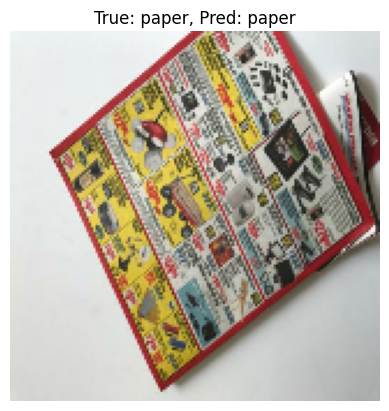

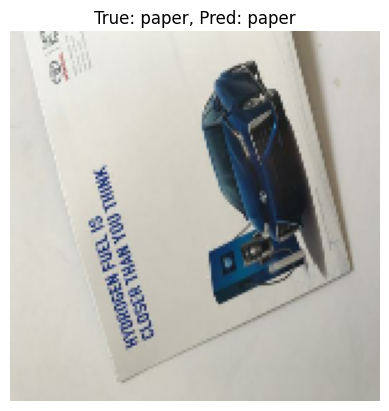

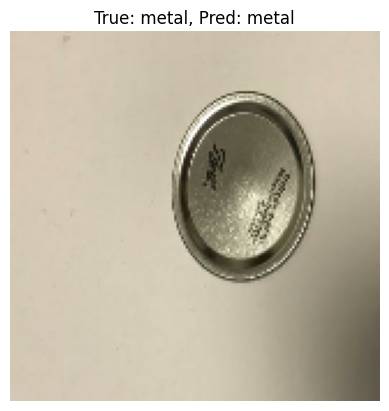

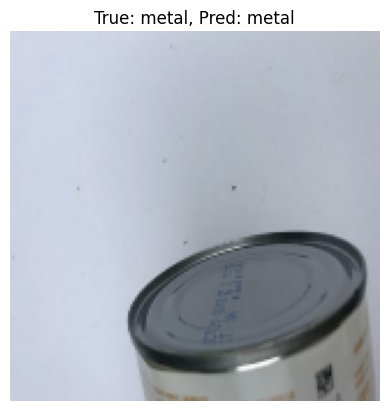

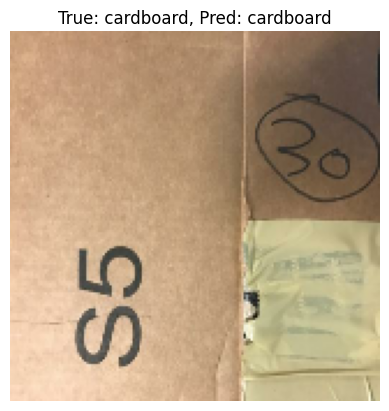

In [41]:
display_image_prediction(EN_B0_model, test_ds_eval)

In [42]:
#Saving the model
EN_B0_model.save('Efficientnetv2b0.keras')

#Loading the model
EN_B0_model = tf.keras.models.load_model('Efficientnetv2b0.keras')

In [43]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input #Required method for preprocessing images 

In [44]:
#Preprocessing required for MobileNet
def preprocess(image, label):
#     image = tf.image.resize(image, (160,160))
    image = preprocess_input(image)  # Normalize for MobileNetV2
    return image, label

#Creating new preprocessed dataset for MobileNet
train_ds_mn = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds_mn = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds_mn = test_ds_eval.map(preprocess)

In [45]:
#Base model for MobileNetV2
base_model_2 = MobileNetV2(include_top = False,
                            input_shape = (160,160,3),
                            weights = 'imagenet')

base_model_2.trainable = True
for layer in base_model_2.layers[:60]:
    base_model_2.trainable = False

In [46]:
#Data augmentation for mobilenet otherwise the input image size mismatch occurs if previous data augmentation is used
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip('vertical'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [47]:
#Early Stopping to monitor the validation loss
early = tf.keras.callbacks.EarlyStopping(
monitor = 'val_loss',
patience = 3,
restore_best_weights = True
)

In [48]:
#Model building for MobileNet
MN_model = Sequential([layers.Input(shape = (160,160,3)),
    data_augmentation,
    base_model_2,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation = 'softmax')
])

In [49]:
#Compiling model
MN_model.compile(
optimizer = optimizers.Adam(learning_rate = 1e-3),
loss= 'sparse_categorical_crossentropy',
metrics = ['accuracy']
)

In [50]:
MN_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [51]:
base_model_2.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [52]:
#Training MobileNet
epochs = 15

history_2 = MN_model.fit(
train_ds_mn,
validation_data = val_ds_mn,
epochs = epochs,
class_weight = class_weights,
batch_size = 32,
callbacks = [early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2952 - loss: 1.9210 - val_accuracy: 0.6554 - val_loss: 0.9300
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5969 - loss: 1.1018 - val_accuracy: 0.7089 - val_loss: 0.8356
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6533 - loss: 0.9497 - val_accuracy: 0.7347 - val_loss: 0.7603
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7104 - loss: 0.8100 - val_accuracy: 0.7545 - val_loss: 0.7214
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7206 - loss: 0.7841 - val_accuracy: 0.7426 - val_loss: 0.7074
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7411 - loss: 0.6922 - val_accuracy: 0.7545 - val_loss: 0.7186
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7692 - loss: 0.6718 - val_accuracy: 0.7624 - val_loss: 0.6997
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7608 - loss: 0.6445 - val_accuracy: 0.7683 - val_

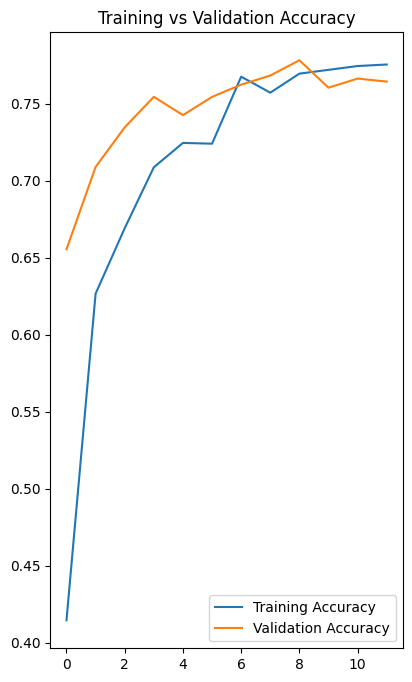

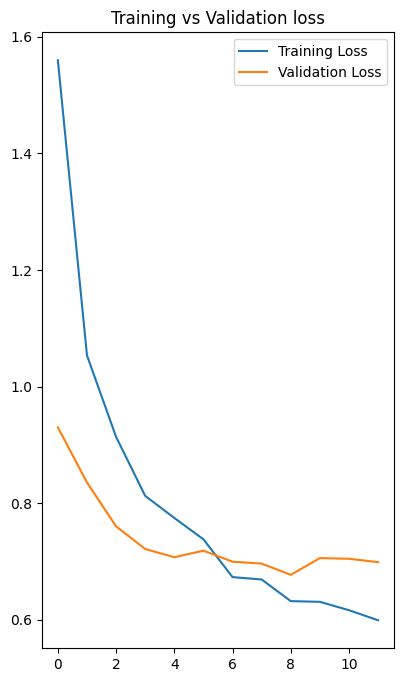

In [53]:
#Performance evaluation for MobileNet
plot_training_validation_acc_loss(history_2)

In [54]:
#Loss and accuracy for MobileNet
loss, accuracy = MN_model.evaluate(test_ds_mn)
print(f"Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 679ms/step - accuracy: 0.8209 - loss: 0.6113
Test accuracy is 0.7969, Test loss is 0.6299


In [55]:
#Confusion Matrix
y_pred_probs_2 = MN_model.predict(test_ds_mn)

y_pred_2 = np.argmax(y_pred_probs_2, axis = 1)

cm_2 = confusion_matrix(y_true, y_pred_2)

print(cm_2)
print(classification_report(y_true, y_pred_2))

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step
[[25  0  1  2  0  2]
 [ 0 37  6  0  4  0]
 [ 0  5 40  1  2  2]
 [ 1  2  0 54  1  4]
 [ 0  7  1  1 33  3]
 [ 0  0  2  3  2 15]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.73      0.79      0.76        47
           2       0.80      0.80      0.80        50
           3       0.89      0.87      0.88        62
           4       0.79      0.73      0.76        45
           5       0.58      0.68      0.62        22

    accuracy                           0.80       256
   macro avg       0.79      0.78      0.78       256
weighted avg       0.80      0.80      0.80       256



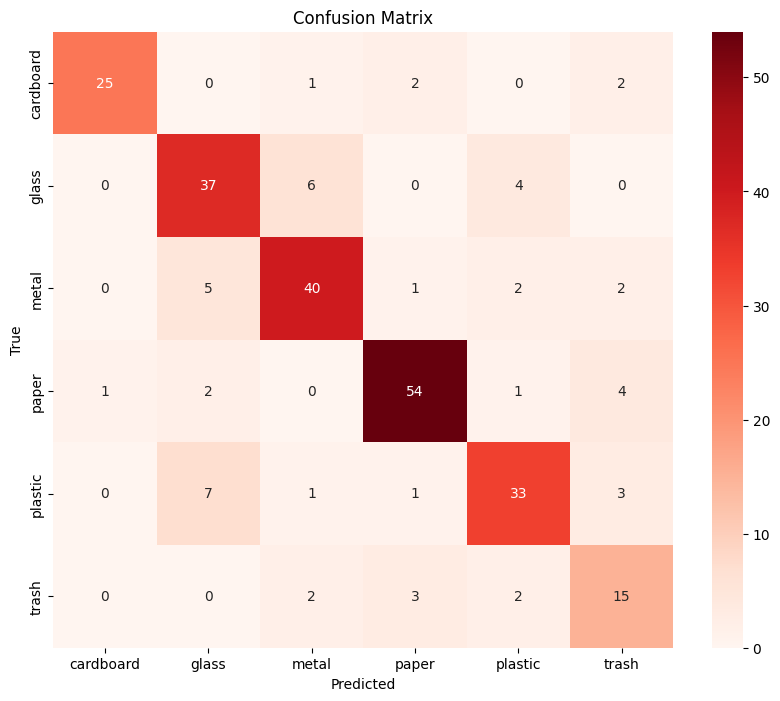

In [56]:
plot_confusion_matrix(cm_2,"Reds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


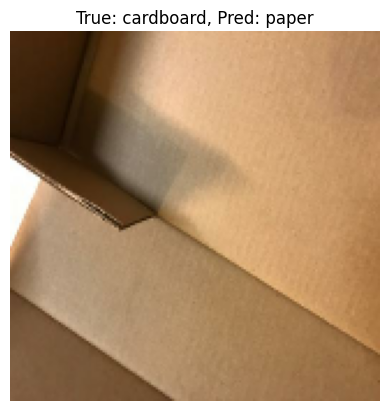

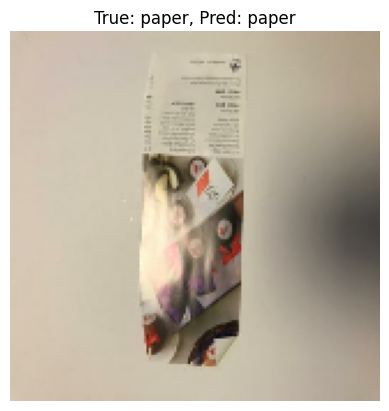

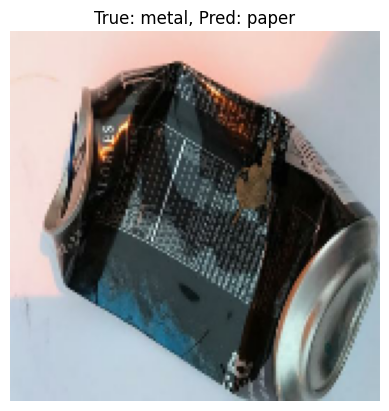

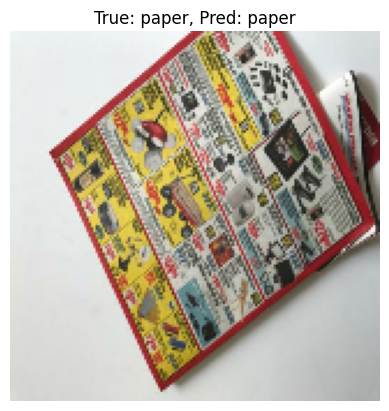

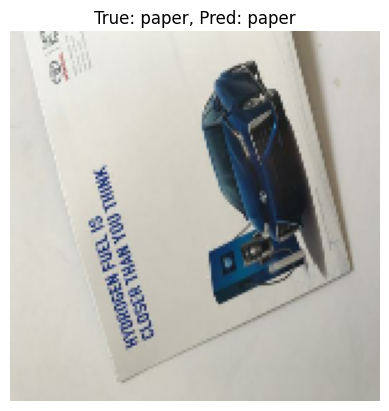

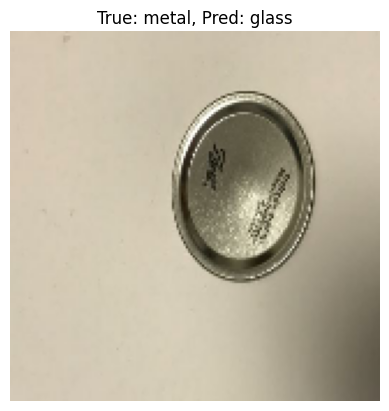

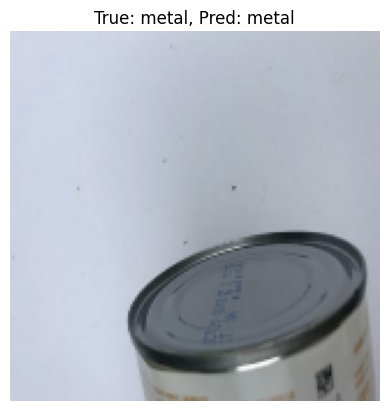

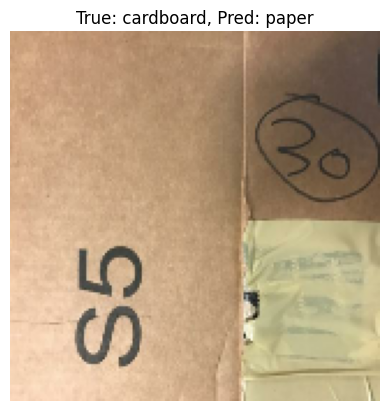

In [57]:
display_image_prediction(MN_model, test_ds_eval)

In [58]:
#Saving model
MN_model.save('Mobilenetv2.keras')

#Loading the model
MN_model = tf.keras.models.load_model('Mobilenetv2.keras')

In [ ]:
#Model deploying for EfficientNetV2B2
import subprocess

subprocess.run(["streamlit", "run", "streamlit_code.py"])